In [55]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
BASE_DIR     = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
BASE_RES_DIR = os.path.join(BASE_DIR, 'results')

print(BASE_DIR)
print(BASE_RES_DIR)

/Users/sujitdebnath/Sujit/FAU/5. Winter 2023-24/Project 1 - BioNet/fau-bionets-project-ws23
/Users/sujitdebnath/Sujit/FAU/5. Winter 2023-24/Project 1 - BioNet/fau-bionets-project-ws23/results


In [57]:
def read_csv(csv_fpath):
    return pd.read_csv(csv_fpath, index_col=0)

def map_cell_anno_method_to_col_name(cell_anno_method):
    if cell_anno_method == "SCSA - cellmarker":
        cell_anno_col_name = "scsa_celltype_cellmarker"
    elif cell_anno_method == "SCSA - panglaodb":
        cell_anno_col_name = "scsa_celltype_panglaodb"
    elif cell_anno_method == "MetaTiME":
        cell_anno_col_name = "Major_MetaTiME"
    
    return cell_anno_col_name

def map_col_name_to_cell_anno_method(cell_anno_col):
    if cell_anno_col == "scsa_celltype_cellmarker":
        cell_anno_method = "SCSA - cellmarker"
    elif cell_anno_col == "scsa_celltype_panglaodb":
        cell_anno_method = "SCSA - panglaodb"
    elif cell_anno_col == "Major_MetaTiME":
        cell_anno_method = "MetaTiME"
    
    return cell_anno_method

In [58]:
disease_ids       = sorted([dir for dir in os.listdir(BASE_RES_DIR) if os.path.isdir(os.path.join(BASE_RES_DIR, dir)) and dir != 'summary'])
cell_anno_methods = ['SCSA - cellmarker', 'SCSA - panglaodb', 'MetaTiME']
cell_anno_df      = read_csv(csv_fpath=os.path.join(BASE_RES_DIR, 'summary', 'cell_anno_res.csv'))
cell_anno_df

,disease_id,dataset_id,donor,scsa_celltype_cellmarker,scsa_celltype_panglaodb,MetaTiME,Major_MetaTiME
0,diabetesII,dataset1,case,T-cell,T-cell,Pan_Beta-catenin,Pancreatic cell
1,diabetesII,dataset1,case,T-cell,T-cell,T_CD4T-IL7R,T-cell
2,diabetesII,dataset1,case,Natural killer cell,Natural killer cell,T_NK-cytotoxic,T-cell
3,diabetesII,dataset1,case,T-cell,T-cell,Pan_AP1-FOS,Pancreatic cell
4,diabetesII,dataset1,case,Natural killer cell,Natural killer cell,T_CD8T-GZMK-CCL5,T-cell
...,...,...,...,...,...,...,...
64961,mpn,dataset5,control,T-cell,T-cell,T_Treg-T-co-signaling,T-cell
64962,mpn,dataset5,control,T-cell,T-cell,T_CD4T-IL7R,T-cell
64963,mpn,dataset5,control,T-cell,T-cell,T_CD4T-MAIT-Th17,T-cell
64964,mpn,dataset5,control,T-cell,T-cell,Pan_Cycling-MYC,Pancreatic cell


### 1. Distribution of Cell Types Based on Annotation Methods (excluded unknown labels)

In [59]:
def cell_anno_box_plot_based_on_anno_methods(df, cell_anno_method):
    cell_anno_col_name = map_cell_anno_method_to_col_name(cell_anno_method)
    
    # Aggregate counts of cell types for each disease and dataset
    agg_df = df.groupby(['disease_id', 'dataset_id', cell_anno_col_name]).size().reset_index(name='count')

    # Filter out rows with 'Unknown' cell types
    agg_df = agg_df[agg_df[cell_anno_col_name] != 'Unknown']

    # Calculate total count of each cell type across all datasets and diseases
    total_counts = agg_df.groupby(cell_anno_col_name)['count'].sum().reset_index()
    total_counts = total_counts.sort_values(by='count', ascending=False)  # Sort by count

    # Sort agg_df based on total count order
    agg_df[cell_anno_col_name] = pd.Categorical(agg_df[cell_anno_col_name], categories=total_counts[cell_anno_col_name], ordered=True)
    agg_df = agg_df.sort_values(by=cell_anno_col_name)

    # Create a Seaborn box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=agg_df,
        x=cell_anno_col_name,
        y='count',
        hue='disease_id',
        hue_order=sorted(df['disease_id'].unique()),
        gap=0.2,
        palette='Set2'
    )
    plt.title(f'Distribution of Cell Types According to {cell_anno_method}')
    plt.xlabel('Cell Types')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save the plot
    # plt.savefig(os.path.join(BASE_DIR, 'docs', 'report', f'dist1_{cell_anno_method.lower()}.png'))

    plt.show()

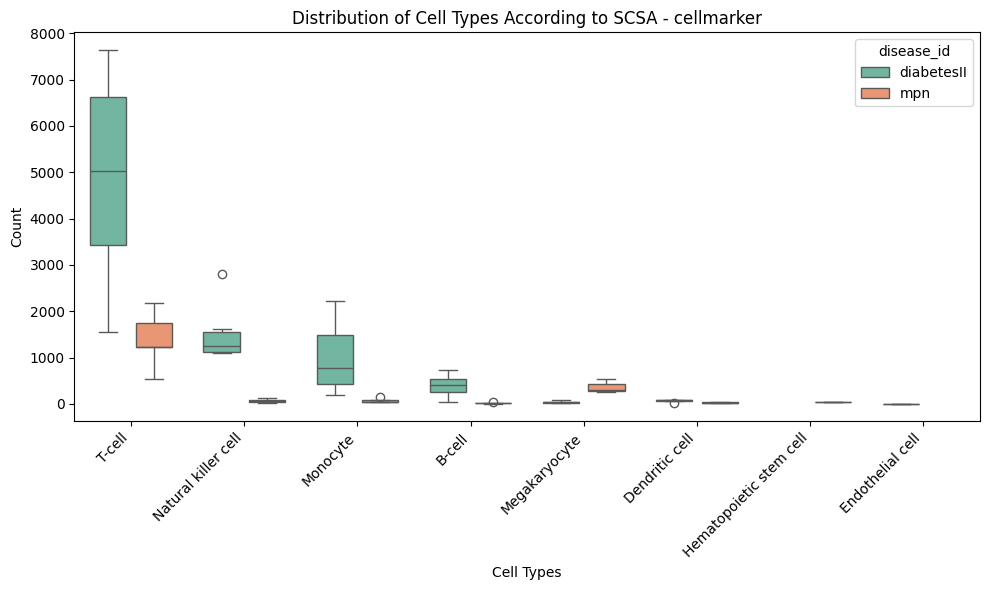

In [60]:
cell_anno_box_plot_based_on_anno_methods(df=cell_anno_df, cell_anno_method=cell_anno_methods[0])

### 2. Distribution of Cell Types for Case vs Control (excluded unknown labels)

In [61]:
def cell_anno_box_plot_case_control(df, disease_id, cell_anno_method):
    cell_anno_col_name = map_cell_anno_method_to_col_name(cell_anno_method)
    
    # Aggregate counts of cell types for each disease, dataset, and donor
    agg_df = df.groupby(['disease_id', 'dataset_id', 'donor', cell_anno_col_name]).size().reset_index(name='count')

    # Filter rows with given disease
    agg_df = agg_df[agg_df['disease_id'] == disease_id]

    # Filter out rows with 'Unknown' cell types
    agg_df = agg_df[agg_df[cell_anno_col_name] != 'Unknown']

    # Calculate total count of each cell type across all datasets and diseases
    total_counts = agg_df.groupby(cell_anno_col_name)['count'].sum().reset_index()
    total_counts = total_counts.sort_values(by='count', ascending=False)  # Sort by count

    # Sort agg_df based on total count order
    agg_df[cell_anno_col_name] = pd.Categorical(agg_df[cell_anno_col_name], categories=total_counts[cell_anno_col_name], ordered=True)
    agg_df = agg_df.sort_values(by=cell_anno_col_name)

    # Create a Seaborn box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=agg_df,
        x='count',
        y=cell_anno_col_name,
        hue='donor',
        hue_order=['control', 'case'],
        gap=0.2,
        palette='Set2'
    )
    plt.title(f'Distribution of Cell Types for Case vs Control ({disease_id.upper()} Disease and {cell_anno_method})')
    plt.xlabel('Count')
    plt.ylabel('Cell Types''Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save the plot
    # plt.savefig(os.path.join(BASE_DIR, 'docs', 'report', f'dist2_{disease_id}_{cell_anno_method.lower()}.jpeg'))

    plt.show()

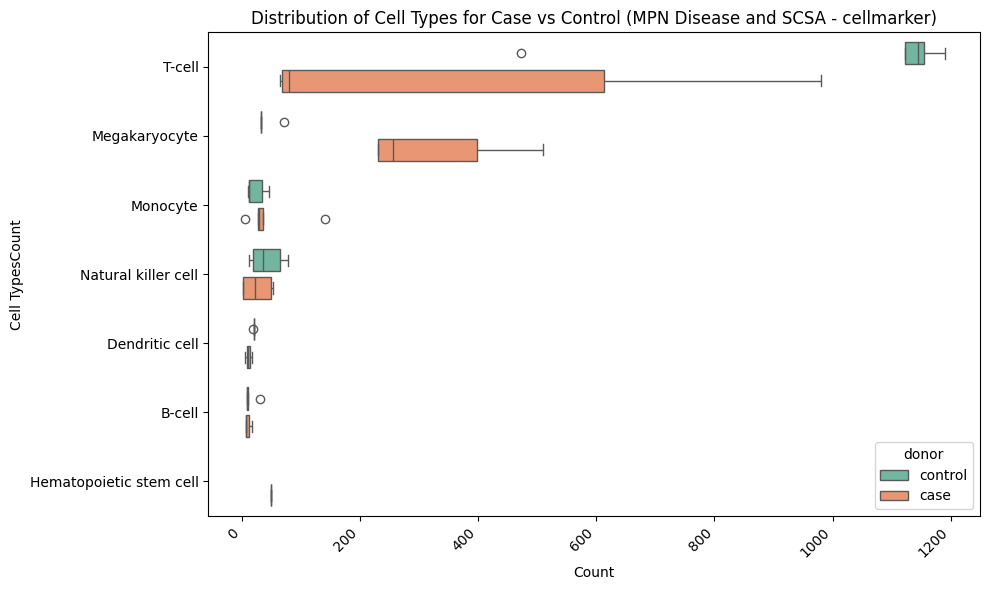

In [62]:
cell_anno_box_plot_case_control(df=cell_anno_df, disease_id='mpn', cell_anno_method=cell_anno_methods[0])

In [63]:
def cell_anno_box_plot_case_control_subplots(df, disease_ids, cell_anno_methods):
    num_diseases = len(disease_ids)
    num_methods  = len(cell_anno_methods)
    
    fig, axes = plt.subplots(num_diseases, num_methods, figsize=(32, 16))
    cap_alpha = ord('a') - 1

    for i, disease_id in enumerate(disease_ids):
        for j, cell_anno_method in enumerate(cell_anno_methods):
            cell_anno_col_name = map_cell_anno_method_to_col_name(cell_anno_method)

            # Aggregate counts of cell types for each disease, dataset, and donor
            agg_df = df.groupby(['disease_id', 'dataset_id', 'donor', cell_anno_col_name]).size().reset_index(name='count')

            # Filter rows with given disease
            agg_df = agg_df[agg_df['disease_id'] == disease_id]

            # Filter out rows with 'Unknown' cell types
            agg_df = agg_df[agg_df[cell_anno_col_name] != 'Unknown']

            # Calculate total count of each cell type across all datasets and diseases
            total_counts = agg_df.groupby(cell_anno_col_name)['count'].sum().reset_index()
            total_counts = total_counts.sort_values(by='count', ascending=False)  # Sort by count

            # Sort agg_df based on total count order
            agg_df[cell_anno_col_name] = pd.Categorical(agg_df[cell_anno_col_name], categories=total_counts[cell_anno_col_name], ordered=True)
            agg_df = agg_df.sort_values(by=cell_anno_col_name)

            # Create a Seaborn box plot
            ax = sns.boxplot(
                data=agg_df,
                x='count',
                y=cell_anno_col_name,
                hue='donor',
                hue_order=['control', 'case'],
                gap=0.2,
                palette='Set2',
                ax=axes[i, j]
            )
            ax.set_title(f'({chr(cap_alpha + 1)}) Disease: {disease_id.upper()} and Method: {cell_anno_method}')
            ax.set_xlabel('Count')
            ax.set_ylabel('Cell Types')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.legend(title='Donor')
            cap_alpha += 1

    plt.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.suptitle(f"Distribution of Cell Types for Case vs Control", fontsize=16, fontweight='bold')
    # plt.savefig(os.path.join(BASE_DIR, 'docs', 'report', 'dist_case_control.jpeg'))

    plt.show()

/var/folders/nf/0v797yys3y9g7vstpx3mfdwh0000gn/T/ipykernel_76351/2200774674.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/nf/0v797yys3y9g7vstpx3mfdwh0000gn/T/ipykernel_76351/2200774674.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/nf/0v797yys3y9g7vstpx3mfdwh0000gn/T/ipykernel_76351/2200774674.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/nf/0v797yys3y9g7vstpx3mfdwh0000gn/T/ipykernel_76351/2200774674.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/nf/0v797yys3y9g7vstpx3mfdwh0000gn/T/ipykernel_76351/2200774674.py:43: UserWarning: 

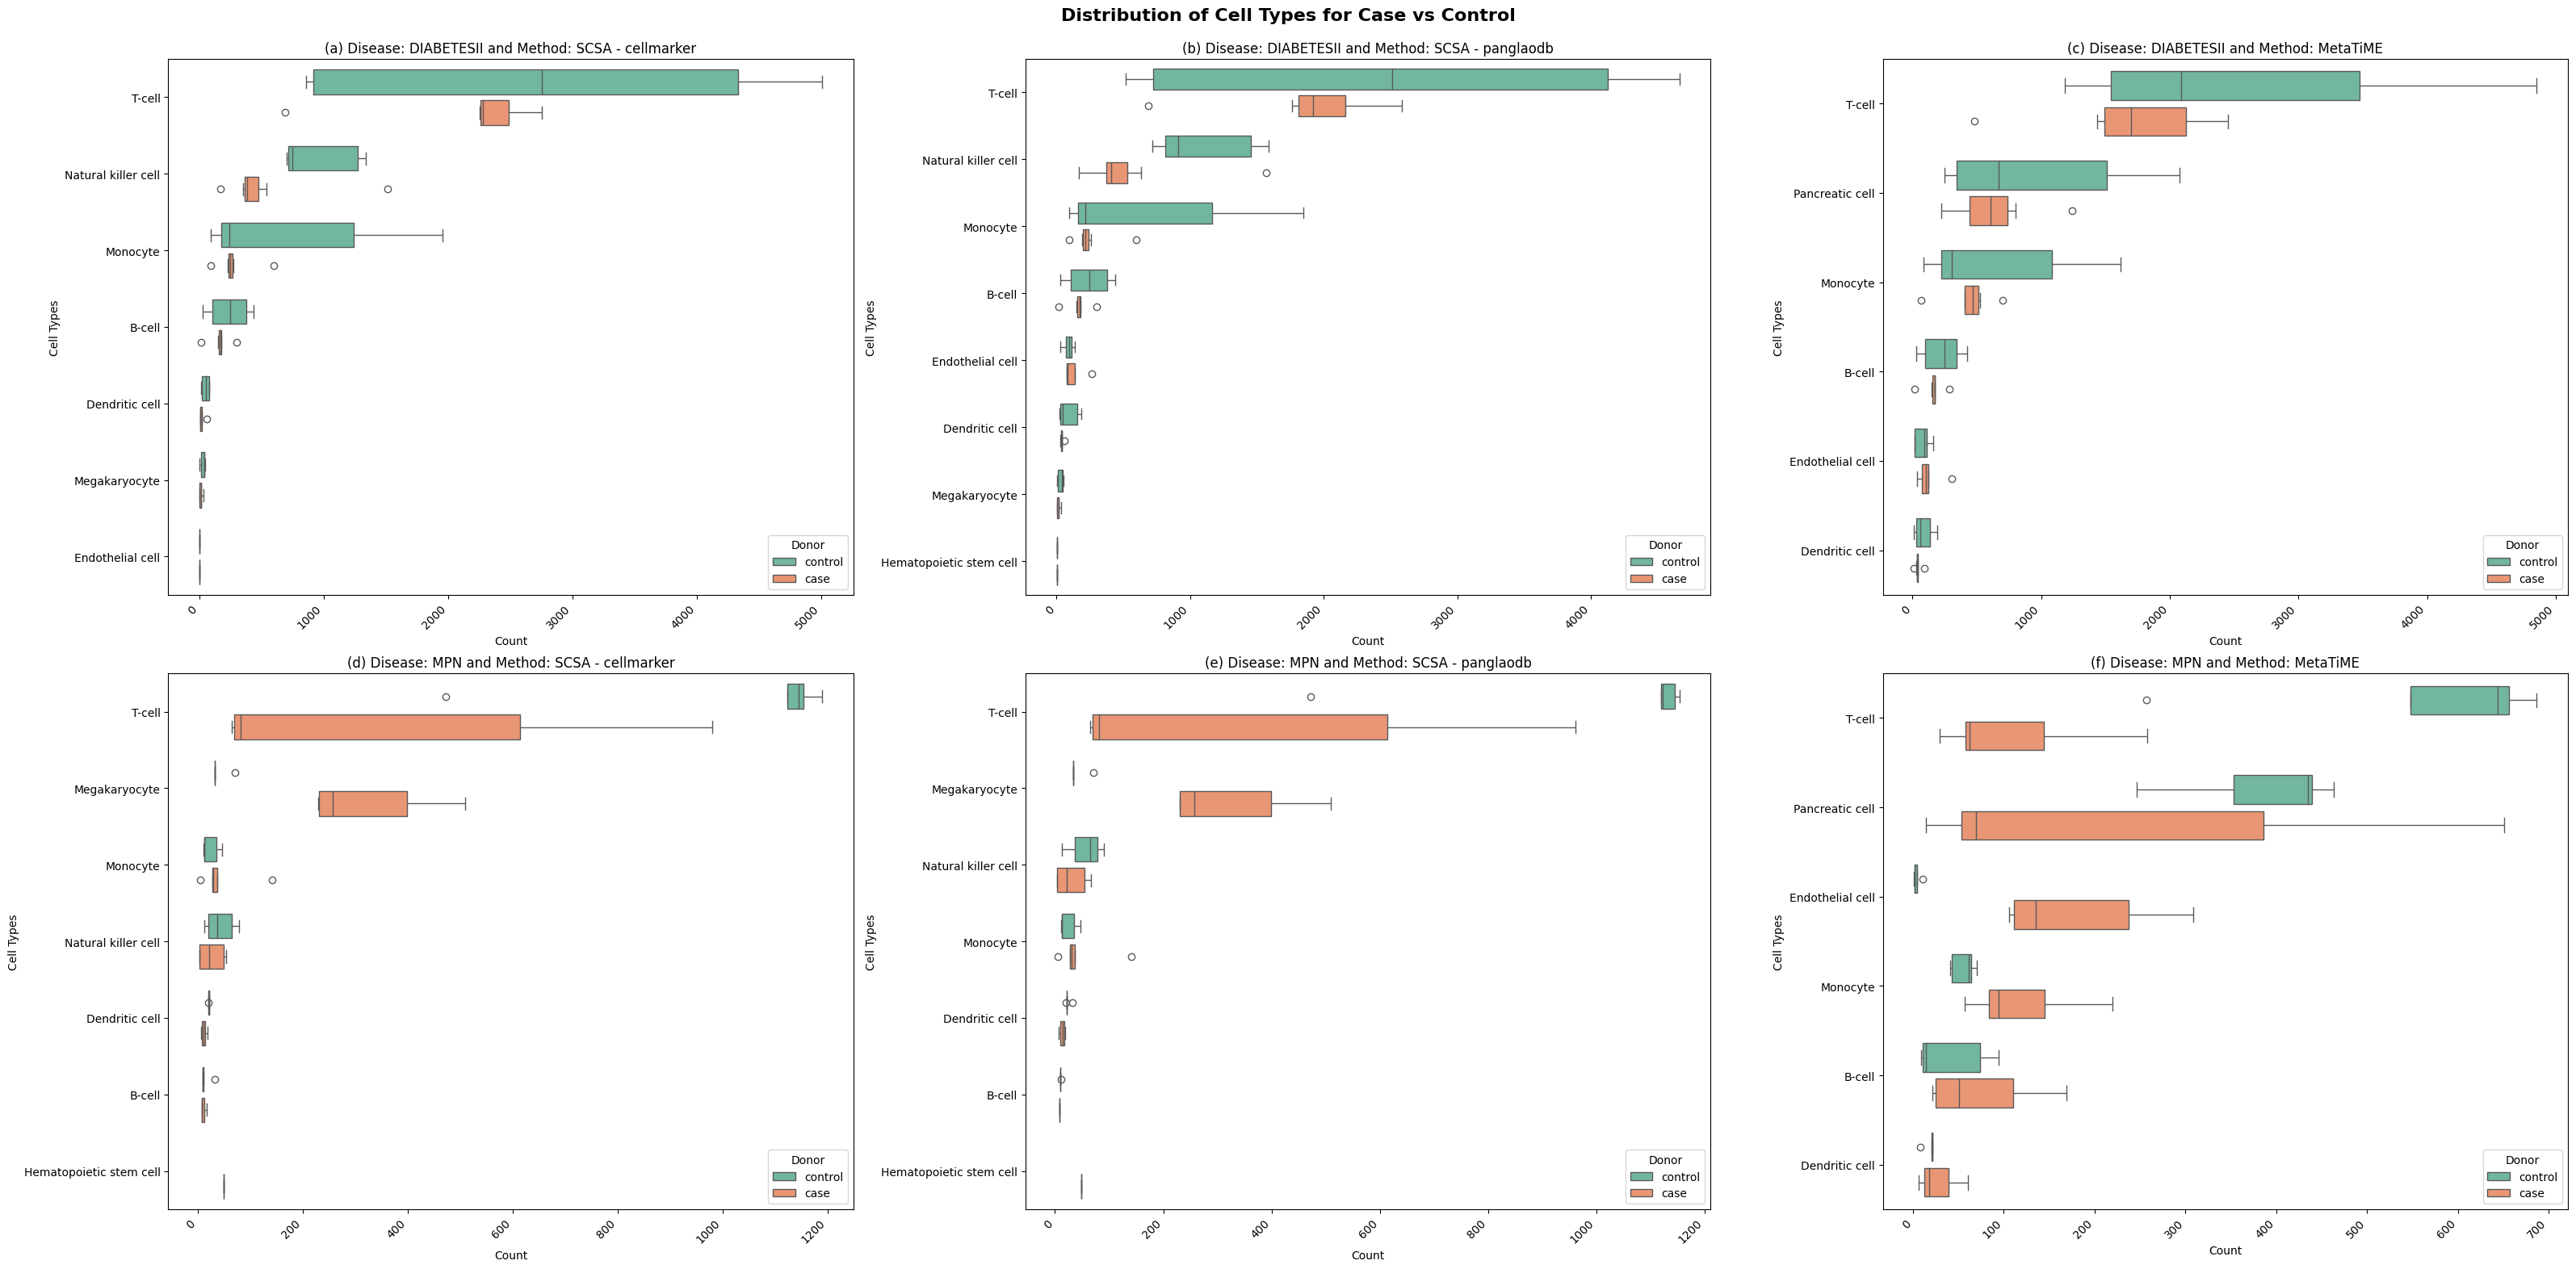

In [64]:
cell_anno_box_plot_case_control_subplots(df=cell_anno_df, disease_ids=disease_ids, cell_anno_methods=cell_anno_methods)

### 3. Distribution of Cell Types According to All Annotation Methods

In [65]:
def cell_anno_box_plot_for_diseases(df, disease_id, cell_anno_methods):
    merged_df = None

    for cell_anno_method in cell_anno_methods:
        cell_anno_col_name = map_cell_anno_method_to_col_name(cell_anno_method)

        agg_df = df.groupby(['disease_id', 'dataset_id', cell_anno_col_name]).size().reset_index(name='count')
        agg_df = agg_df.rename(columns={cell_anno_col_name: 'cell_type'})
        agg_df['method'] = cell_anno_method

        if merged_df is None:
            merged_df = agg_df
        else:
            merged_df = pd.concat([merged_df, agg_df])

    # Filter rows with given disease
    merged_df = merged_df[merged_df['disease_id'] == disease_id]

    # Calculate total count of each cell type across all annotation methods
    total_counts = merged_df.groupby('cell_type')['count'].sum().reset_index()
    total_counts = total_counts.sort_values(by='count', ascending=False)

    # Sort merged_df based on method order and total count order
    merged_df['cell_type'] = pd.Categorical(merged_df['cell_type'], categories=total_counts['cell_type'], ordered=True)
    merged_df['method'] = pd.Categorical(merged_df['method'], categories=cell_anno_methods, ordered=True)
    merged_df = merged_df.sort_values(by=['method', 'cell_type'])

    # Create a Seaborn box plot
    plt.figure(figsize=(12, 8))
    sns.boxplot(
        data=merged_df,
        x='count',
        y='cell_type',
        hue='method',
        gap=0.25,
        palette='tab20'
    )

    plt.title(f'Distribution of Cell Types According to All Annotation Methods for {disease_id.upper()} Disease')
    plt.xlabel('Count')
    plt.ylabel('Cell Types')
    plt.legend()
    plt.tight_layout()

    # Save the plot if needed
    # plt.savefig(os.path.join(BASE_DIR, 'docs', 'report', f'dist3_{disease_id}.jpeg'))

    plt.show()

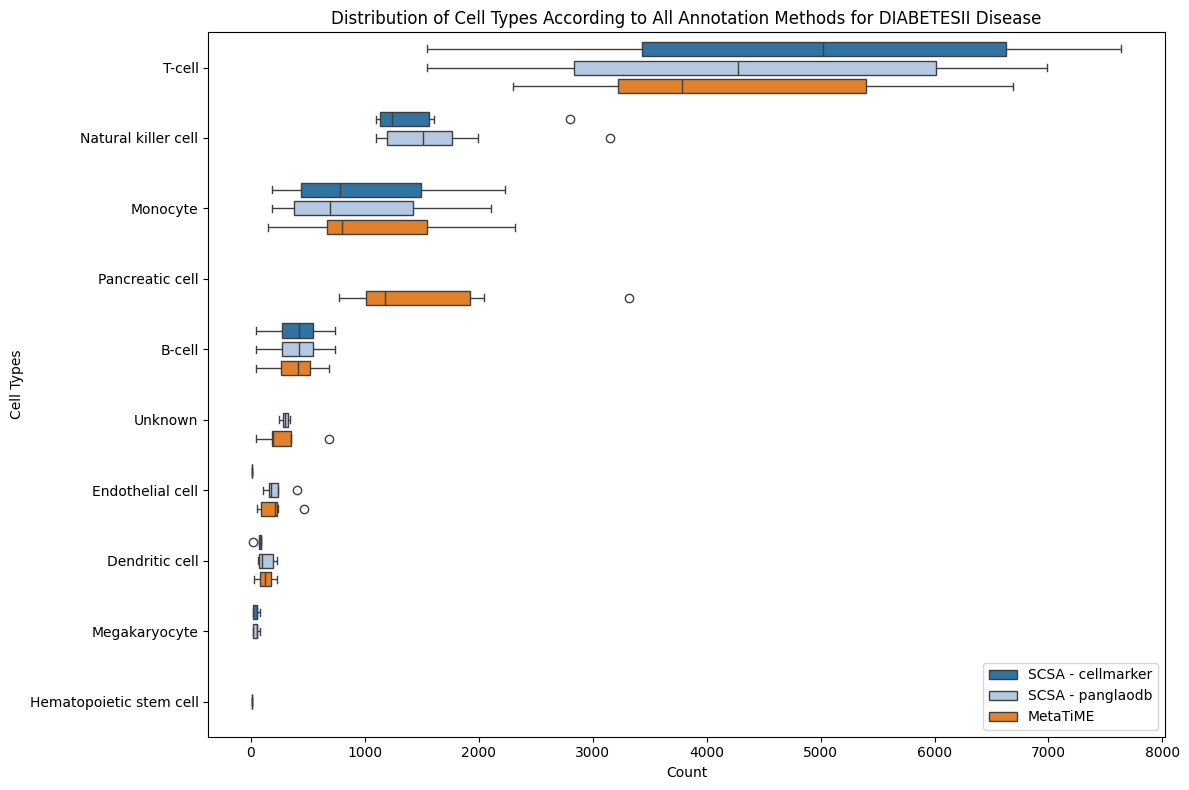

In [66]:
cell_anno_box_plot_for_diseases(df=cell_anno_df, disease_id='diabetesII', cell_anno_methods=cell_anno_methods)

In [67]:
def cell_anno_box_plot_for_diseases_subplots(df, disease_ids, cell_anno_methods):
    fig, axes = plt.subplots(1, len(disease_ids), figsize=(20, 6))
    cap_alpha = ord('a')

    for i, disease_id in enumerate(disease_ids):
        merged_df = None

        for cell_anno_method in cell_anno_methods:
            cell_anno_col_name = map_cell_anno_method_to_col_name(cell_anno_method)

            agg_df = df.groupby(['disease_id', 'dataset_id', cell_anno_col_name]).size().reset_index(name='count')
            agg_df = agg_df.rename(columns={cell_anno_col_name: 'cell_type'})
            agg_df['method'] = cell_anno_method

            if merged_df is None:
                merged_df = agg_df
            else:
                merged_df = pd.concat([merged_df, agg_df])

        # Filter rows with given disease
        merged_df = merged_df[merged_df['disease_id'] == disease_id]

        # Calculate total count of each cell type across all annotation methods
        total_counts = merged_df.groupby('cell_type')['count'].sum().reset_index()
        total_counts = total_counts.sort_values(by='count', ascending=False)

        # Sort merged_df based on method order and total count order
        merged_df['cell_type'] = pd.Categorical(merged_df['cell_type'], categories=total_counts['cell_type'], ordered=True)
        merged_df['method'] = pd.Categorical(merged_df['method'], categories=cell_anno_methods, ordered=True)
        merged_df = merged_df.sort_values(by=['method', 'cell_type'])

        # Create a Seaborn box plot
        sns.boxplot(
            data=merged_df,
            x='count',
            y='cell_type',
            hue='method',
            gap=0.25,
            palette='tab20',
            ax=axes[i]
        )

        axes[i].set_title(f'({chr(cap_alpha+i)}) {disease_id.upper()}')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel('Cell Types')
        axes[i].legend()

    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.suptitle(f"Distribution of Cell Types According to All Annotation Methods", fontsize=16, fontweight='bold')
    # plt.savefig(os.path.join(BASE_DIR, 'docs', 'report', 'dist_anno_methods.jpeg'))

    plt.show()


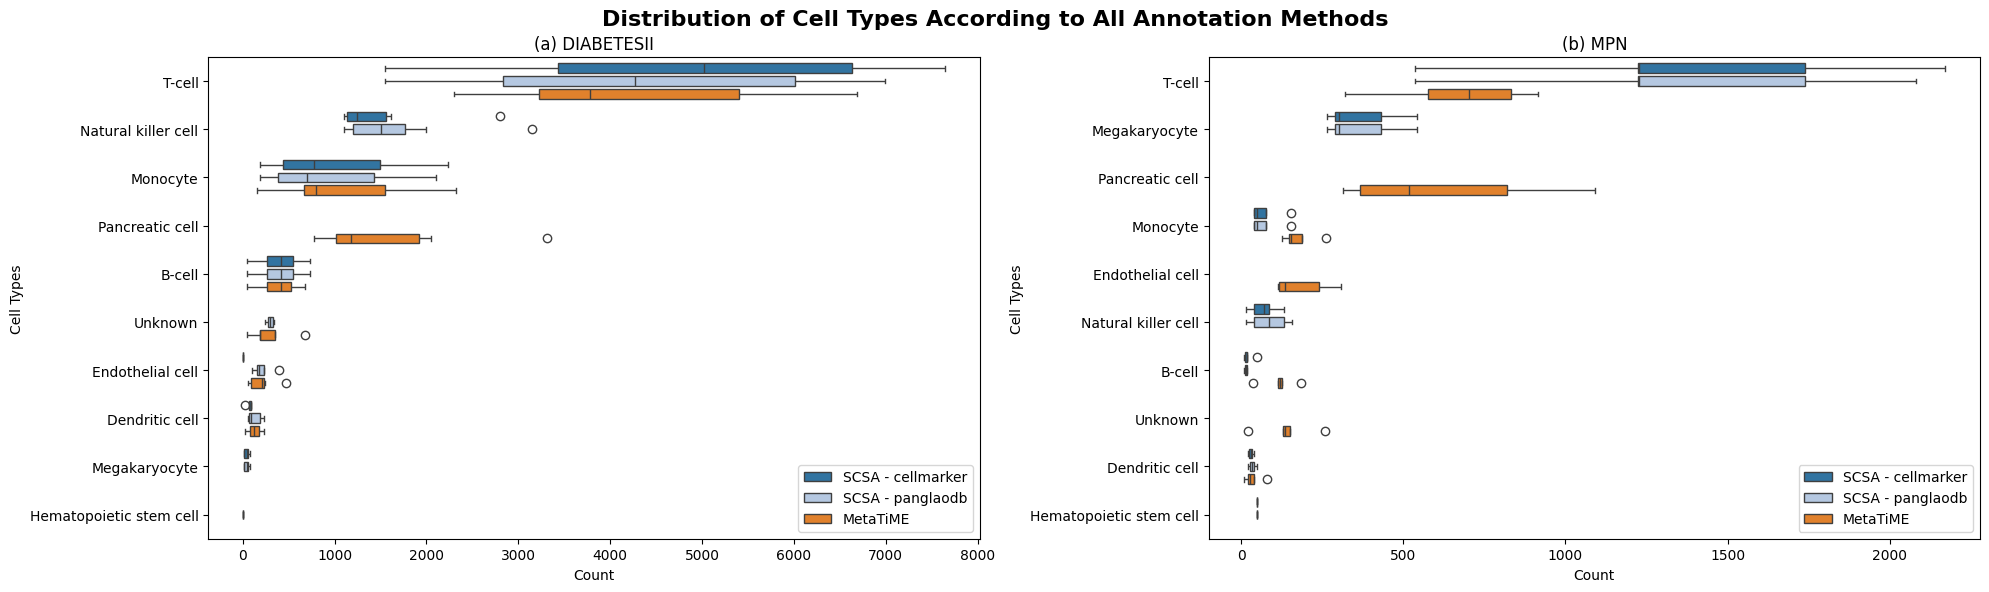

In [68]:
cell_anno_box_plot_for_diseases_subplots(df=cell_anno_df, disease_ids=disease_ids, cell_anno_methods=cell_anno_methods)

### 4. Heatmap of Cell Type Co-occurrence

In [69]:
def cell_anno_heatmap(df, disease_id, anno_method1, anno_method2):
    cell_anno_col1 = map_cell_anno_method_to_col_name(anno_method1)
    cell_anno_col2 = map_cell_anno_method_to_col_name(anno_method2)

    # Filter data by disease_id
    df_filtered = df[df['disease_id'] == disease_id]

    # Compute the co-occurrence matrix
    co_occurrence_matrix = df_filtered.groupby([cell_anno_col1, cell_anno_col2]).size().unstack(fill_value=0)
    
    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        co_occurrence_matrix,
        annot=True,
        fmt='d',  # Display integer values
        linewidths=0.5,
        linecolor='grey',
        cmap='inferno_r'
    )

    # Customize the plot
    plt.title(f"Cell Type Co-occurrence Heatmap for {disease_id.upper()} Disease")
    plt.xlabel(anno_method2)
    plt.ylabel(anno_method1)

    plt.show()

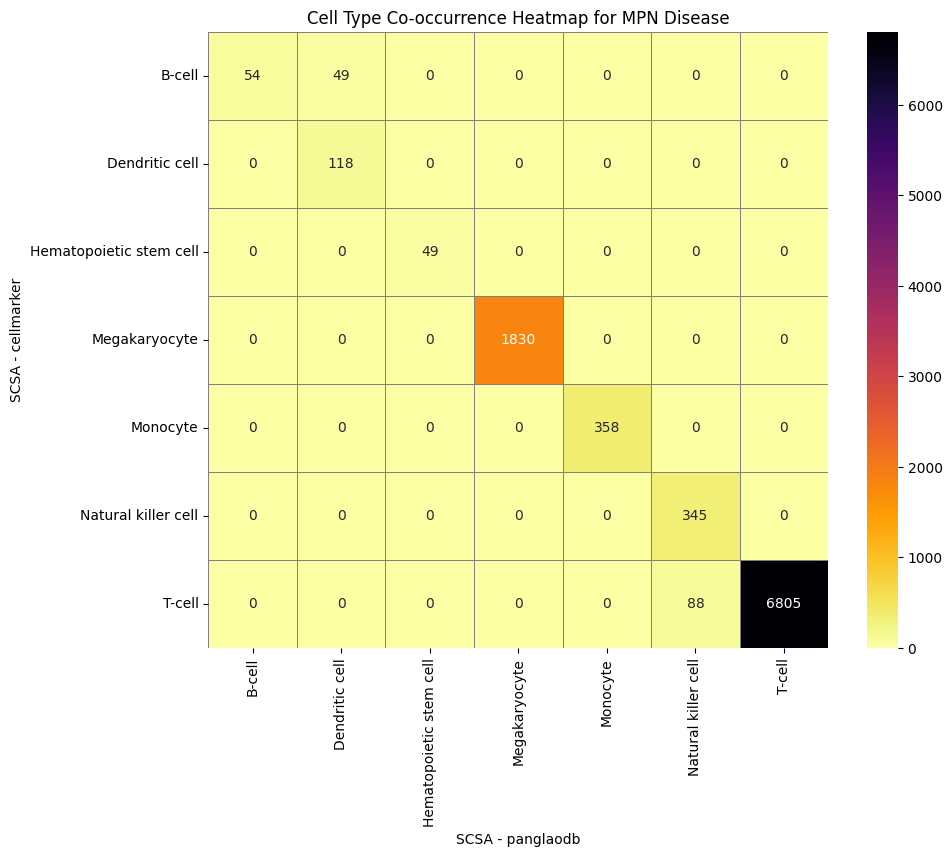

In [70]:
cell_anno_heatmap(df=cell_anno_df, disease_id='mpn', anno_method1=cell_anno_methods[0], anno_method2=cell_anno_methods[1])

In [71]:
def cell_anno_heatmap_subplots(df, disease_ids, cell_anno_methods):
    fig, axes = plt.subplots(len(disease_ids), len(cell_anno_methods), figsize=(35, 16))
    cap_alpha = ord('a') - 1

    for xax, disease_id in enumerate(disease_ids):
        yax = 0

        for i, cell_anno_method1 in enumerate(cell_anno_methods):
            for cell_anno_method2 in cell_anno_methods[i+1:]:
                cell_anno_col1 = map_cell_anno_method_to_col_name(cell_anno_method1)
                cell_anno_col2 = map_cell_anno_method_to_col_name(cell_anno_method2)

                # Filter data by disease_id
                df_filtered = df[df['disease_id'] == disease_id]

                # Compute the co-occurrence matrix
                co_occurrence_matrix = df_filtered.groupby([cell_anno_col1, cell_anno_col2]).size().unstack(fill_value=0)

                # Filter out rows and columns with all zero values
                co_occurrence_matrix = co_occurrence_matrix.loc[(co_occurrence_matrix != 0).any(axis=1), (co_occurrence_matrix != 0).any(axis=0)]

                # Create the heatmap
                sns.heatmap(
                    co_occurrence_matrix,
                    annot=True,
                    fmt='d',  # Display integer values
                    linewidths=0.4,
                    linecolor='grey',
                    cmap='inferno_r',
                    annot_kws={"size": 14},
                    ax=axes[xax, yax]
                )

                # Customize the plot
                axes[xax, yax].set_title(f"({chr(cap_alpha + 1)})")
                axes[xax, yax].set_xlabel(cell_anno_method2)
                axes[xax, yax].set_ylabel(cell_anno_method1)
                yax += 1
                cap_alpha += 1
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.94)
    plt.suptitle(f"Cell Type Co-occurrence Heatmap for {', '.join([d.upper() for d in disease_ids])} Diseases", fontsize=16, fontweight='bold')
    # plt.savefig(os.path.join(BASE_DIR, 'docs', 'report', 'heatmap.jpeg'))

    plt.show()

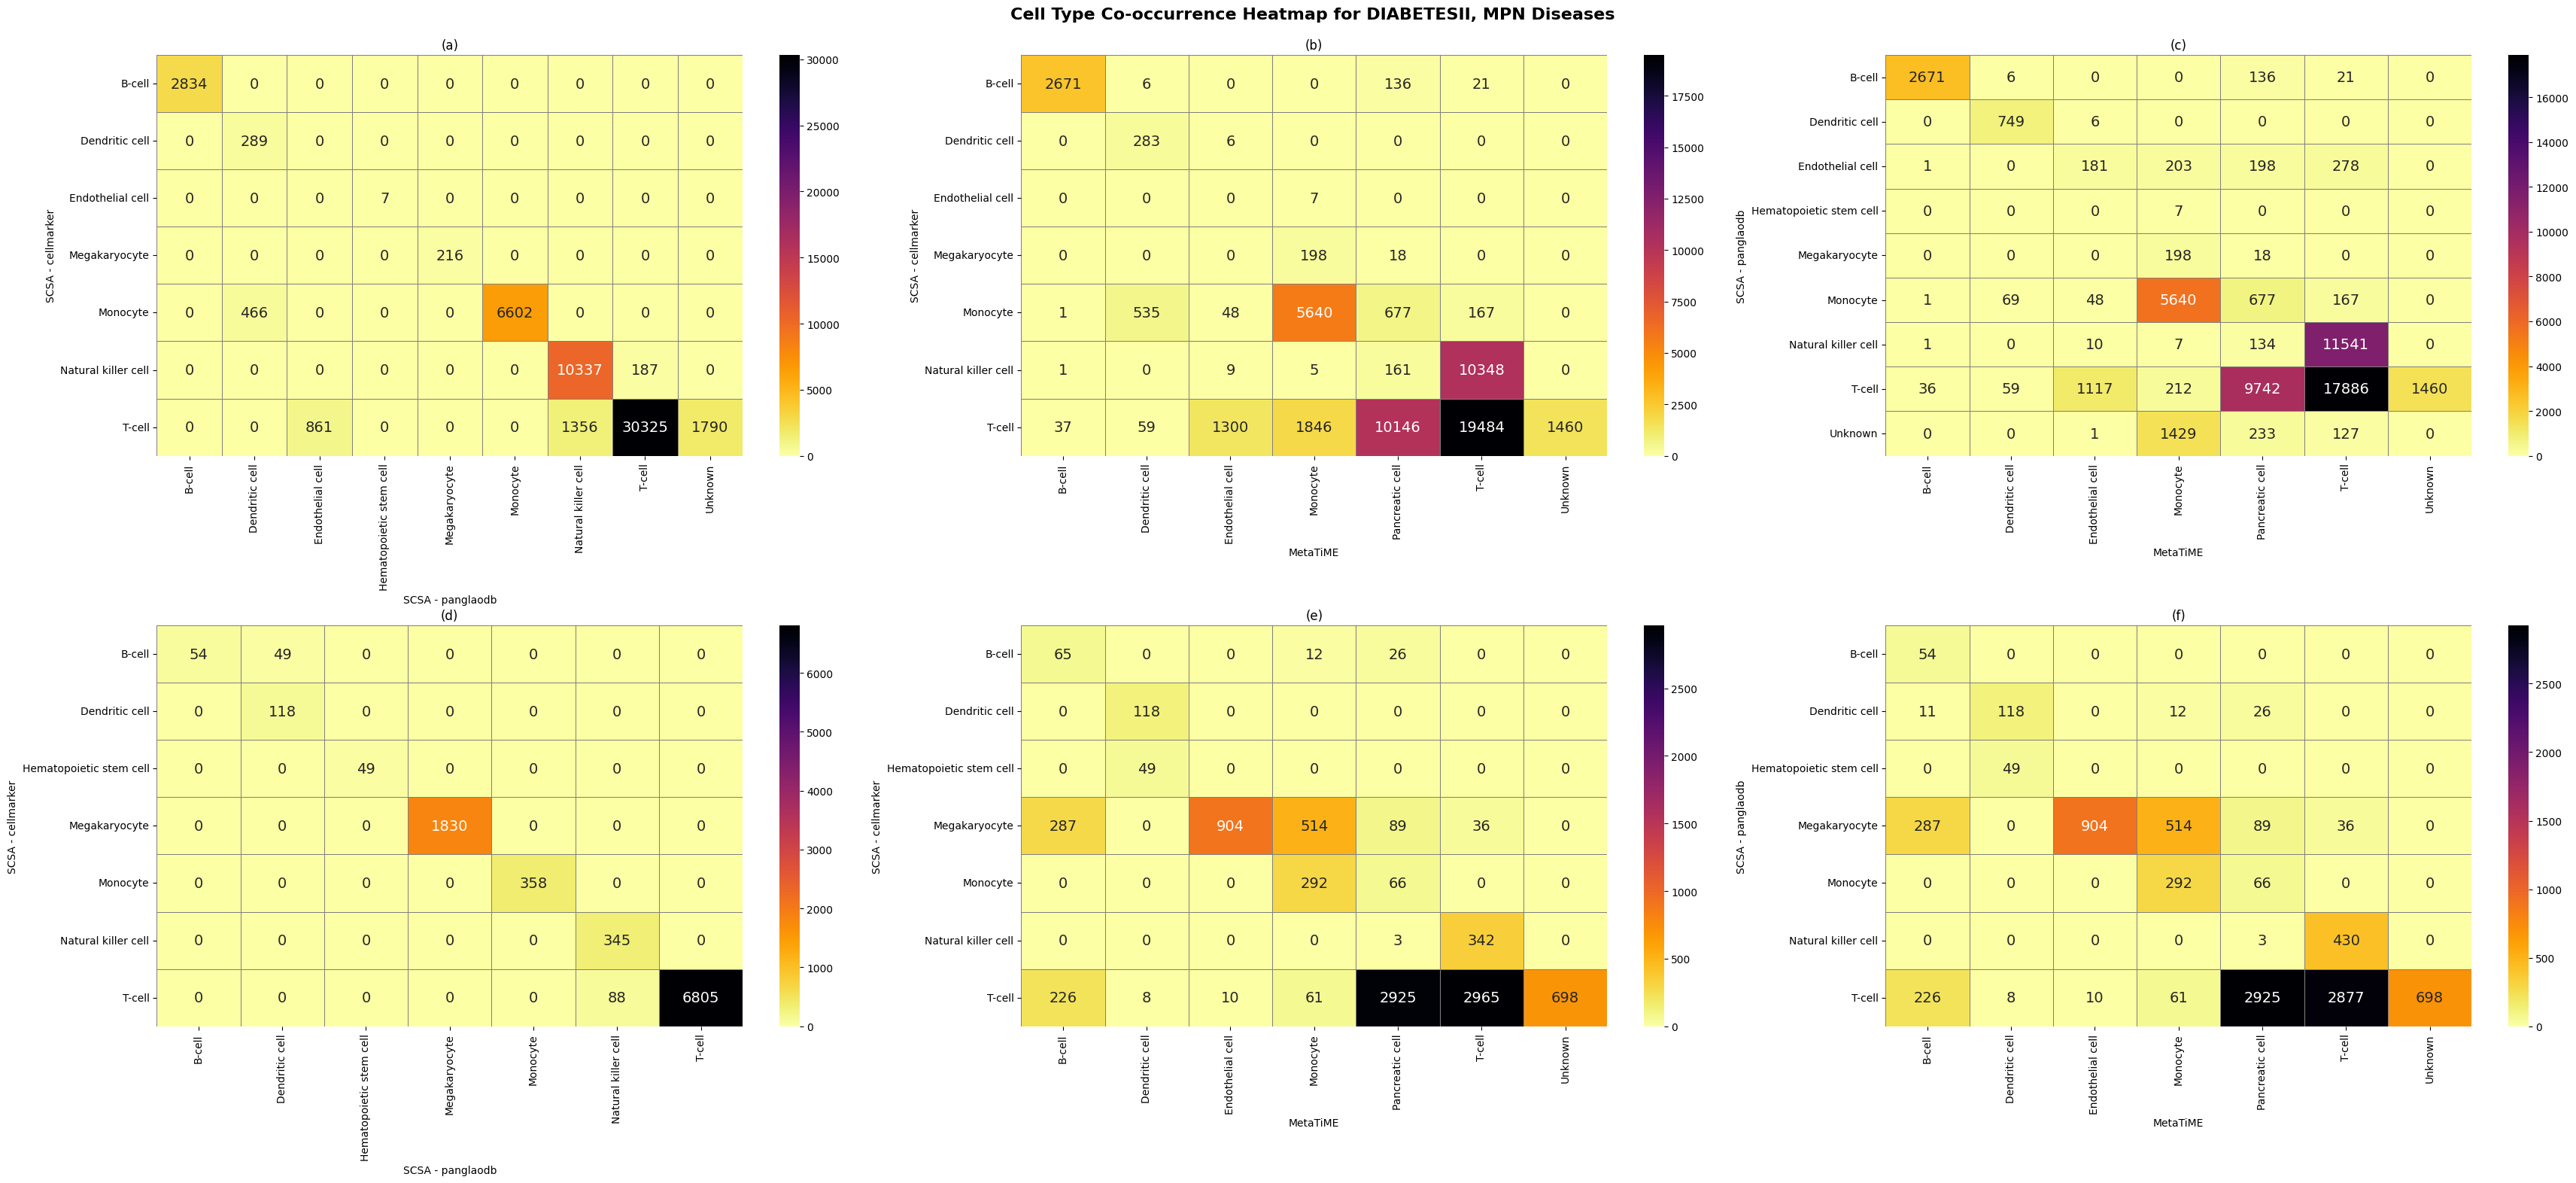

In [72]:
cell_anno_heatmap_subplots(df=cell_anno_df, disease_ids=disease_ids, cell_anno_methods=cell_anno_methods)